# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [ ]:
# Code Here
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from plotnine import ggplot, aes, geom_point, geom_line, theme_minimal, labs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
pip install palmerpenguins

In [ ]:
from palmerpenguins import load_penguins

In [ ]:
penguins = load_penguins()
df = pd.get_dummies(penguins, columns = ["species", 'sex', 'island'])
df = df.dropna()

In [ ]:
y = df["bill_depth_mm"]

all_features = (["bill_length_mm", "flipper_length_mm", "body_mass_g", "species_Chinstrap", "species_Gentoo", "island_Dream", "island_Torgersen", "sex_male"])

X_all = df[all_features].dropna()
y_all = y.loc[X_all.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [ ]:
# Best Multiple Linear Regression Model from Before
# Model 4 - Bill Depth vs. Bill Length, Flipper Length, Body Mass, Species, Island, and Sex
numeric_vars = ["bill_length_mm", "flipper_length_mm", "body_mass_g"]
dummy_vars   = ["species_Chinstrap", "species_Gentoo", "island_Dream", "island_Torgersen", "sex_male"]

ct = ColumnTransformer([
    ("scale_numeric", StandardScaler(), numeric_vars),
    ("pass_dummies", "passthrough", dummy_vars)
])

lr_pipe = Pipeline([
    ("preprocessing", ct),
    ("lr", LinearRegression())
])

lr_pipe.fit(X_train, y_train)

y_pred_train = lr_pipe.predict(X_train)
y_pred_test  = lr_pipe.predict(X_test)

lr_rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_train))
lr_rmse_te = np.sqrt(mean_squared_error(y_test,  y_pred_test))

lr_rmse = -cross_val_score(lr_pipe, X, y, cv = 5, scoring = "neg_root_mean_squared_error").mean()


print(f"Train RMSE: {lr_rmse_tr:}")
print(f"Test RMSE : {lr_rmse_te:}")
print(f"RMSE: {lr_rmse}")


Train RMSE: 0.7899625627828379
Test RMSE : 0.7931070425730464
RMSE: 0.882646404007313


In [ ]:
# kNN Model 1
X = df.drop(["bill_depth_mm"], axis = 1)
y = df["bill_depth_mm"]

ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(),
      make_column_selector(dtype_include = ['int64', 'float64', 'bool']))
  ],
  remainder = "drop"
)

knn5_pipe = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsRegressor(n_neighbors = 5))
])

knn5_rmse = -cross_val_score(knn5_pipe, X, y, cv = 5, scoring = "neg_root_mean_squared_error").mean()
knn5_rmse

np.float64(0.9589274494727077)

In [ ]:
# kNN Model 2
X = df.drop(["bill_depth_mm"], axis = 1)
y = df["bill_depth_mm"]

ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(),
      make_column_selector(dtype_include = ['int64', 'float64', 'bool']))
  ],
  remainder = "drop"
)

knn15_pipe = Pipeline([
    ("preprocessing", ct),
    ("knn2", KNeighborsRegressor(n_neighbors = 15))
])

knn15_rmse = -cross_val_score(knn15_pipe, X, y, cv = 5, scoring = "neg_root_mean_squared_error").mean()
knn15_rmse

np.float64(0.9058687576790675)

In [ ]:
# Decision Tree Model
X = df.drop(["bill_depth_mm"], axis = 1)
y = df["bill_depth_mm"]

dt_pipe = Pipeline([
    ("decision_tree", DecisionTreeRegressor())
])

dt_rmse = -cross_val_score(dt_pipe, X, y, cv = 5, scoring = "neg_root_mean_squared_error").mean()
dt_rmse

np.float64(1.2221312611510122)

In [ ]:
# rmse for each model
results = pd.DataFrame({
    "Model": ["Multiple Linear Regression", "kNN (k=5)", "kNN (k=15)", "Decision Tree"],
    "RMSE": [lr_rmse, knn5_rmse, knn15_rmse, dt_rmse]
})
results

,Model,RMSE
0,Multiple Linear Regression,0.882646
1,kNN (k=5),0.958927
2,kNN (k=15),0.905869
3,Decision Tree,1.222131


The best model was the multiple linear regression model becuase it had the lowest RMSE value at 0.8826.

In [ ]:
# separating training and testing
def rmse_pipeline(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    yhat_tr = pipe.predict(X_tr)
    yhat_te = pipe.predict(X_te)
    tr_rmse = mean_squared_error(y_tr, yhat_tr)
    te_rmse = mean_squared_error(y_te, yhat_te)
    return {"Model": name, "Train RMSE": tr_rmse, "Test RMSE": te_rmse}

results = []

results.append(rmse_pipeline(
    "Multiple Linear Regression", lr_pipe,  X_train, y_train, X_test, y_test))
results.append(rmse_pipeline(
    "kNN (k = 5)", knn5_pipe, X_train, y_train, X_test, y_test))
results.append(rmse_pipeline(
    "kNN (k = 15)", knn15_pipe, X_train, y_train, X_test, y_test))
results.append(rmse_pipeline(
    "Decision Tree", dt_pipe,   X_train, y_train, X_test, y_test))

results_df = (pd.DataFrame(results).sort_values("Test RMSE"))
results_df


,Model,Train RMSE,Test RMSE
0,Multiple Linear Regression,0.624041,0.629019
2,kNN (k = 15),0.628655,0.669329
1,kNN (k = 5),0.542261,0.691060
3,Decision Tree,0.000000,1.287558


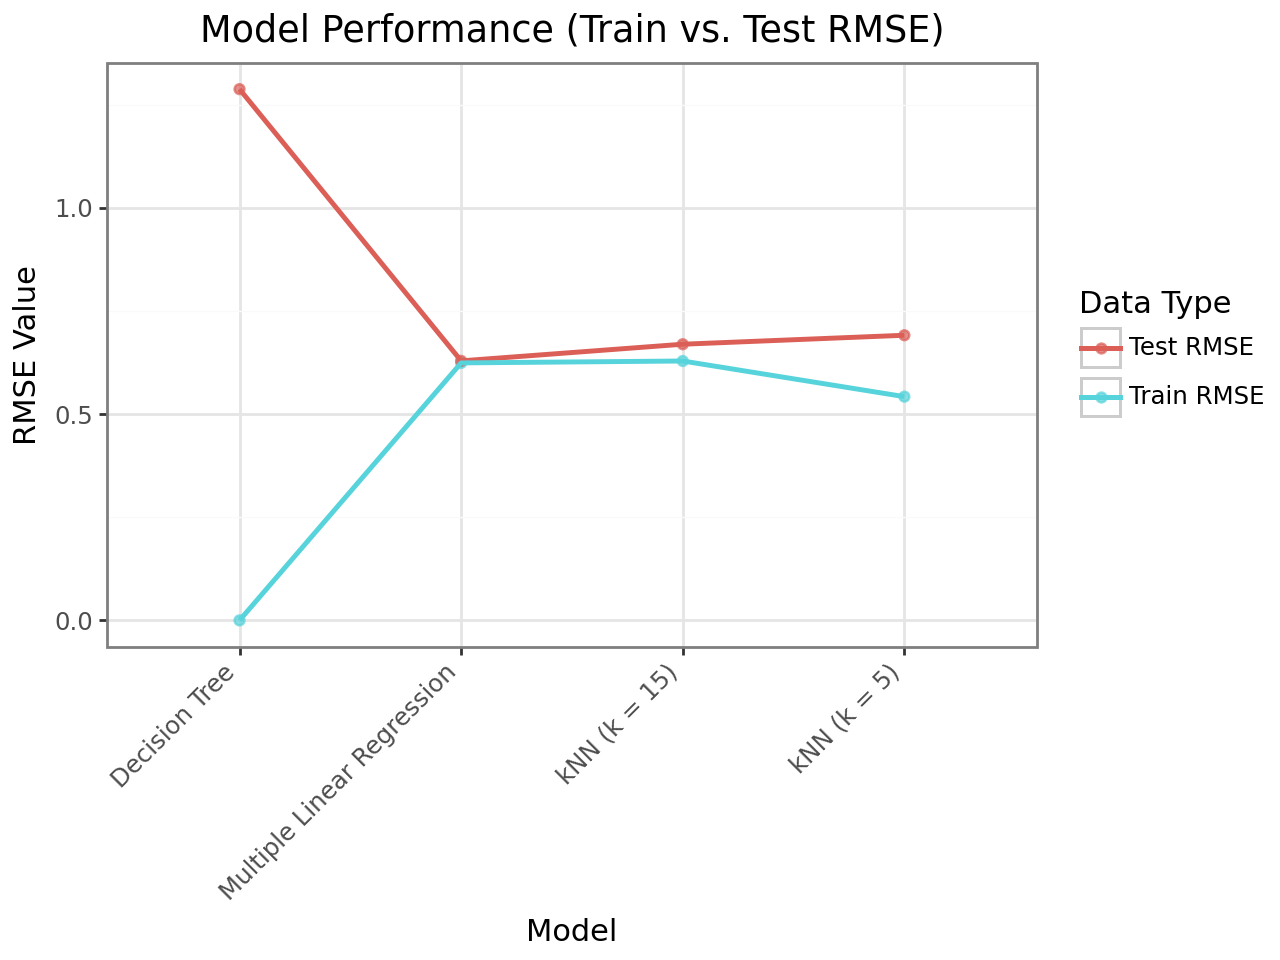

In [55]:
# plot the rmse for training and testing error for each of the models
from plotnine import *

results_long = pd.melt(results_df,
                       id_vars = "Model", value_vars = ["Train RMSE", "Test RMSE"], var_name = "Data Type", value_name = "RMSE")

(ggplot(results_long, aes(
    x = "Model",
    y = "RMSE",
    color = "Data Type",
    group = "Data Type"
))
 + geom_point(alpha = 0.7)
 + geom_line(size = 1)
 + labs(
    title = "Model Performance (Train vs. Test RMSE)",
    x = "Model",
    y = "RMSE Value"
   )
 + theme_bw()
 + theme(axis_text_x = element_text(angle = 45, hjust = 1))
)

My best model was the multiple linear regression because it's RMSEs for training and testing data were nearly the same and had the best cross validation scores.